<a href="https://colab.research.google.com/github/gon-olmedo/data-science-cookbook/blob/main/Times_Series_Forecasting/03_Moving_Average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px

The process is:


1.   Gather Data
2.   is the Model Stationary? : ADF Test -> large negative ADF stat % p-valUe below 0.05
3.   Apply Transformations
4.   Plot ACF & check if there's autocorrelation





## 1. Gather data

In [2]:
# let's get some data
file = 'https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/widget_sales.csv'

df = pd.read_csv(file)

df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [3]:
import datetime
# transform index into dates

# set the start date
start_dt = '2019-01-01'

# create an array of the start date repeated as needed
start_dates = np.full(shape=len(df.index),
                      fill_value=start_dt,
                      dtype=np.dtype('datetime64[ns]'))

# to each date of the array add the corresponding int from index
dates = start_dates + pd.to_timedelta(df.index, unit='D')

# assign back to original df
df.index = dates

# Since we know the time frequncy of th index is daily, we can set it up
# it will come in handy for timeseries analysis later and avoid warnings
df.index.freq = 'D'

# Voila
df.head()

,widget_sales
2019-01-01,50.496714
2019-01-02,50.805493
2019-01-03,51.477758
2019-01-04,53.542228
2019-01-05,54.873108


In [4]:
# let's chart
fig = px.line(df,
              x=df.index, y='widget_sales')

fig.update_yaxes(title='Widget sales (k$)')
fig.update_xaxes(title='Time',
                 dtick='M1') # Control spacing of ticks to be 1 month

fig.show()

## 2. Is the Model Stationary?

Test ADF and P-Value
We look for a large negative number in the ADF and a small (below 0.05 on P-Value)

In [5]:
# the fast and dirty way is just to import an existing method
from statsmodels.tsa.stattools import adfuller
 
ADF_result = adfuller(df['widget_sales'])
 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.5121662069359048
p-value: 0.5274845352272605


Above results show that the model is not Stationary so we have to apply transformations

## 3. Apply Transformations

In [6]:
# We will use differentiation
# meaning we will compute the diference of element n with element n-1
# since the first element has not preceding one, the resulting array
# is one element shorter that the oriinal

widget_sales_diff = np.diff(df['widget_sales'], n=1)


widget_sales_diff[:5]

array([0.30877844, 0.67226491, 2.06447025, 1.33088006, 0.01203396])

In [7]:
# we plot
fig = px.line(y=widget_sales_diff,
              x=df.index[1:]) # np.diff removed a row

fig.update_yaxes(title='Widget sales - diff(k$)')
fig.update_xaxes(title='Time',
                 dtick='M1')

fig.show()

Test ADF and P-Value
We look for a large negative number in the ADF and a small (below 0.05 on P-Value)

In [8]:
# test ADF
ADF_result = adfuller(widget_sales_diff)
 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.576657780341959
p-value: 7.076922818587193e-19


This time the results are suficient, so we can move to the next step and check the autocorrelation

## 4. PLOT ACF and check for Autocorrelation

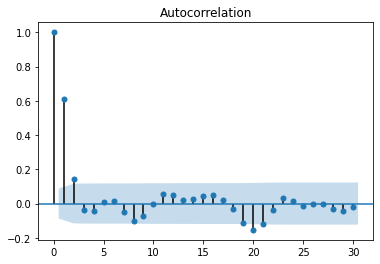

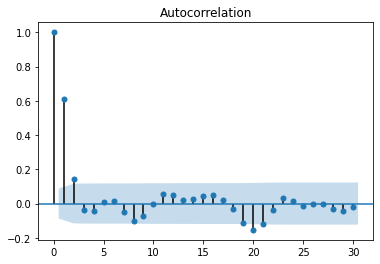

In [9]:
# import plotting tool for ACF
from statsmodels.graphics.tsaplots import plot_acf
 
plot_acf(widget_sales_diff, lags=30)

## 5. Does the Autocorrelation abrutly becomes non-signofocant after lag q

In [10]:
# we will use the diff as a df
df_diff = pd.DataFrame({'widget_sales_diff':widget_sales_diff})

# we assign the proper date range to the index
df_diff.index = df.index[1:]

# split the data
train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

449
50


In [11]:
# we will chart multiple charts in the same figure so we need subplots
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [12]:
# set fig parameters
fig = make_subplots(cols=1, rows=2,
                    shared_xaxes=True,
                    vertical_spacing=0.02)

# set each graph
fig.add_trace(
    go.Scatter(x=df.index, y=df['widget_sales']),
    row=1, col=1,
)

fig.add_trace(
    go.Scatter(x=df.index[1:], y=widget_sales_diff),
    row=2, col=1
)

# Update axes
fig.update_yaxes(title_text='Widget sales (k$)', row=1, col=1)
fig.update_yaxes(title_text='Widget sales - diff (k$)', row=2, col=1)
fig.update_xaxes(title='Time', row=2, col=1)

fig.update_layout(showlegend=False)

fig.show()

In [13]:
# forecast
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
  total_len = train_len + horizon

  if method == 'mean':
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i].values)
      pred_mean.extend(mean for _ in range(window))

    return pred_mean

  elif method == 'last':
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value



  elif method == 'MA':
    pred_MA = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(0,0,2))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean.iloc[-window:]
      pred_MA.extend(oos_pred)

    return pred_MA

In [15]:
pred_df = test.copy()
 
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2
 
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')
 
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA
 
pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
2020-03-26,-1.170131,0.034319,-1.803658,-1.078833
2020-03-27,0.580967,0.034319,-1.803658,-0.273309
2020-03-28,-0.144902,0.032861,0.580967,0.781223
2020-03-29,-0.096564,0.032861,0.580967,0.234969
2020-03-30,-0.372334,0.032183,-0.096564,0.168994


In [17]:
# It's chart time

fig = px.line(pd.concat([train[-20:], pred_df], axis='rows'),
              x=pd.concat([train[-20:], pred_df], axis='rows').index, y=['widget_sales_diff', 'pred_mean', 'pred_last_value', 'pred_MA'])

fig.show()

## Measure Model Performance

In [18]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])
 
print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.9481714497824854


In [47]:
# let's chart it

fig = px.bar(x=['Mean', 'Last value', 'MA(2)'], y=[mse_mean, mse_last, mse_MA])

fig.update_xaxes(title='Methods')
fig.update_yaxes(title='MSE', tick0=0, dtick=0.5)

fig.update_traces(texttemplate="%{y:.2f}", # show value on labels formatted as .2f
                  textposition='outside') # labels to be outsid eof the bars

fig.show()